/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch: 1


Training...: 100%|██████████| 36306/36306 [48:24<00:00, 12.50it/s]


Train Loss: 0.3219865978338273, Train Accuracy: 0.8554076037838163



Testing...: 100%|██████████| 9077/9077 [09:32<00:00, 15.84it/s]


Test Loss: 0.26922870540766314, Test Accuracy: 0.8808805707045667


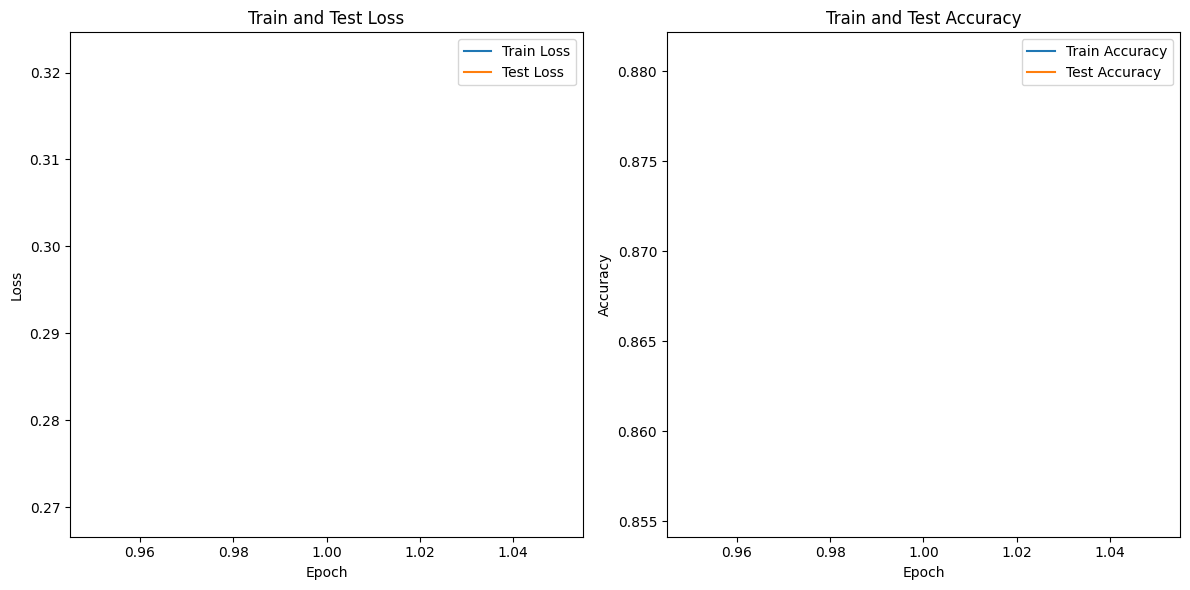

epoch: 2


Training...: 100%|██████████| 36306/36306 [48:29<00:00, 12.48it/s]


Train Loss: 0.26229755542834776, Train Accuracy: 0.8843474293977397



Testing...: 100%|██████████| 9077/9077 [09:34<00:00, 15.79it/s]


Test Loss: 0.2554926824091821, Test Accuracy: 0.8855561064286894


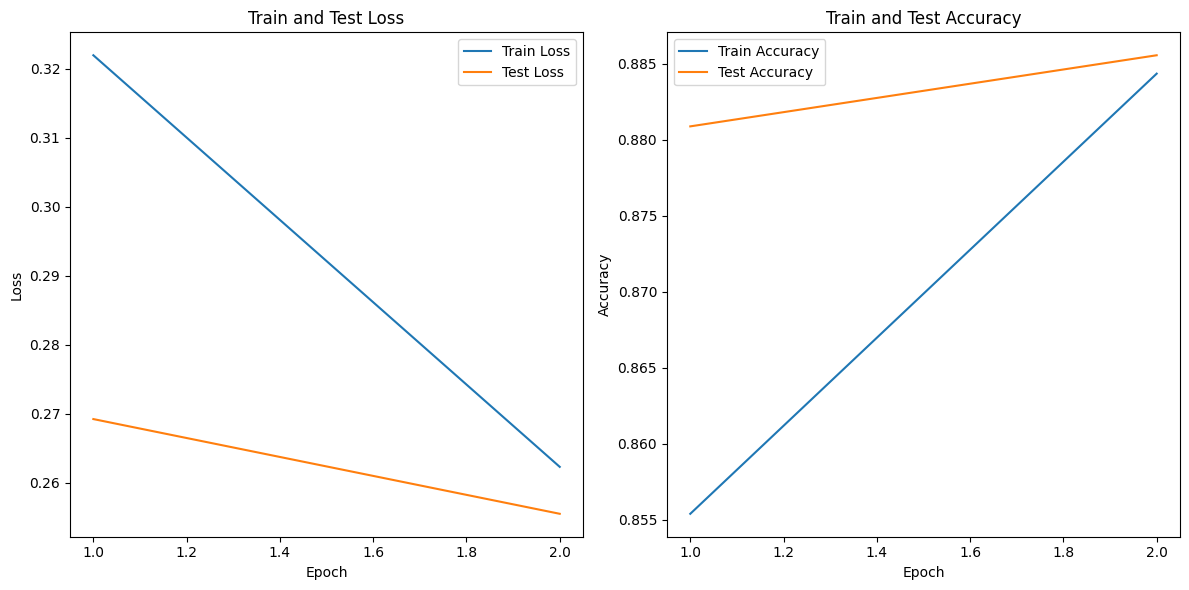

epoch: 3


Training...: 100%|██████████| 36306/36306 [48:29<00:00, 12.48it/s]


Train Loss: 0.2311121550147659, Train Accuracy: 0.8997701822188175



Testing...: 100%|██████████| 9077/9077 [09:33<00:00, 15.81it/s]


Test Loss: 0.253879993314124, Test Accuracy: 0.8913196165922987


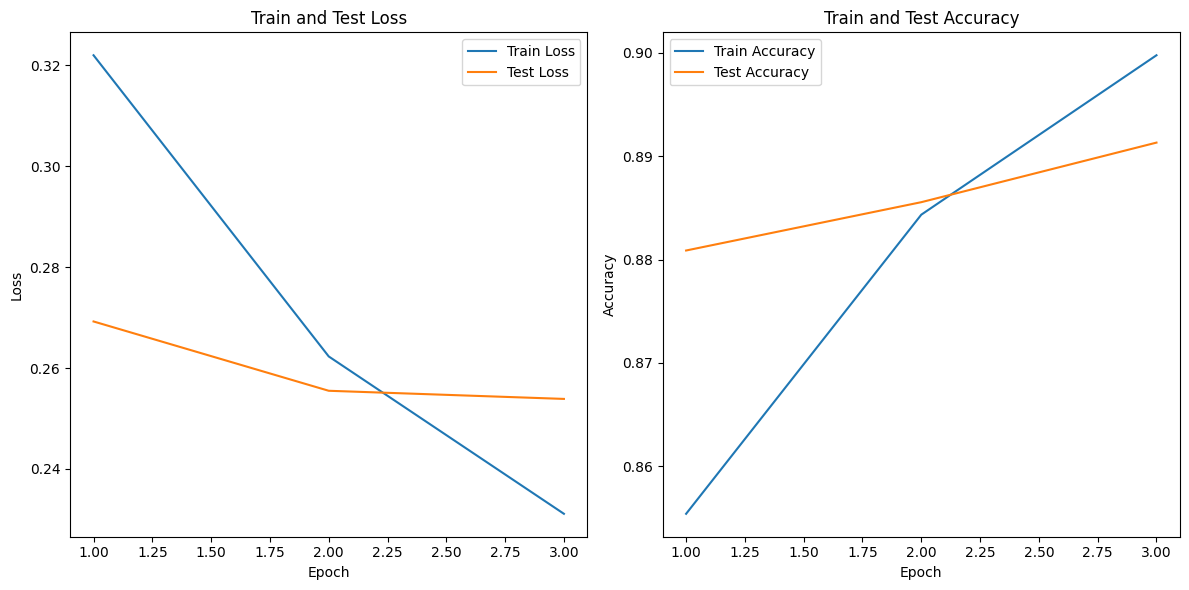

epoch: 4


Training...: 100%|██████████| 36306/36306 [48:28<00:00, 12.48it/s]


Train Loss: 0.20754157328065584, Train Accuracy: 0.9107360194183114



Testing...: 100%|██████████| 9077/9077 [09:39<00:00, 15.67it/s]


Test Loss: 0.25083594301159284, Test Accuracy: 0.8966355423346003


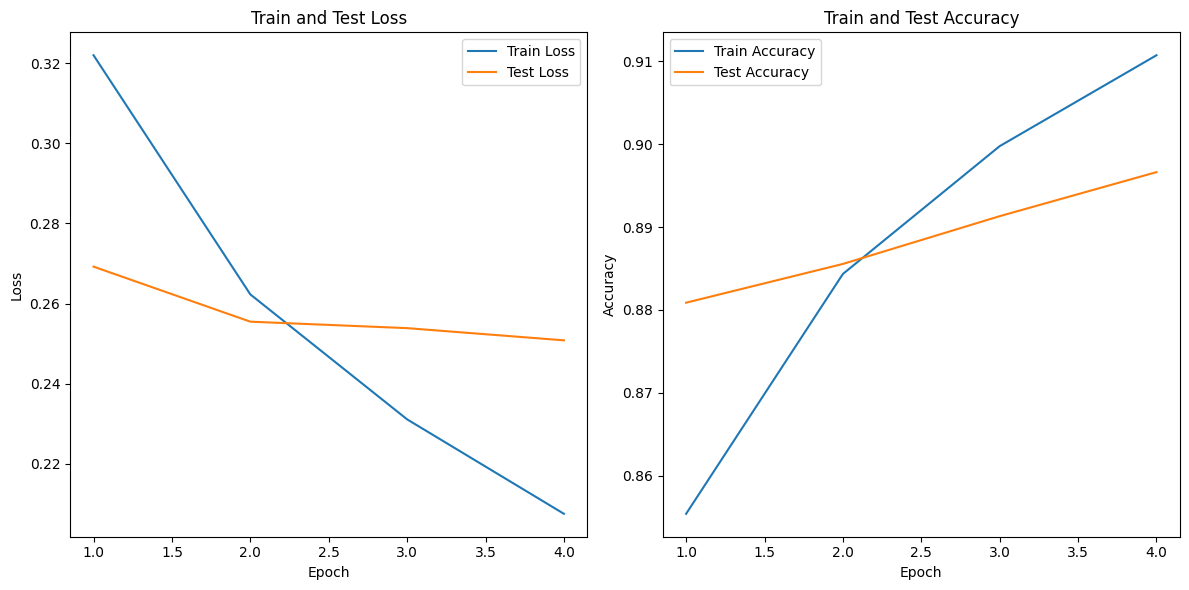

epoch: 5


Training...: 100%|██████████| 36306/36306 [48:34<00:00, 12.46it/s]


Train Loss: 0.18815330549964557, Train Accuracy: 0.9197083810327168



Testing...: 100%|██████████| 9077/9077 [09:34<00:00, 15.79it/s]


Test Loss: 0.2422143055576855, Test Accuracy: 0.9009530105216769


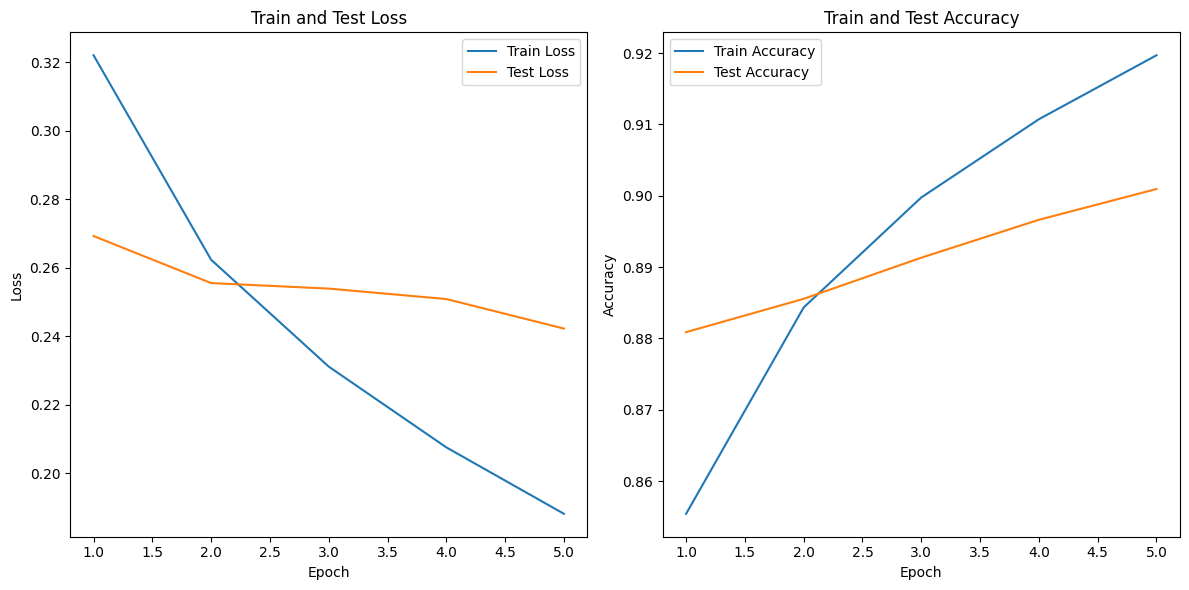

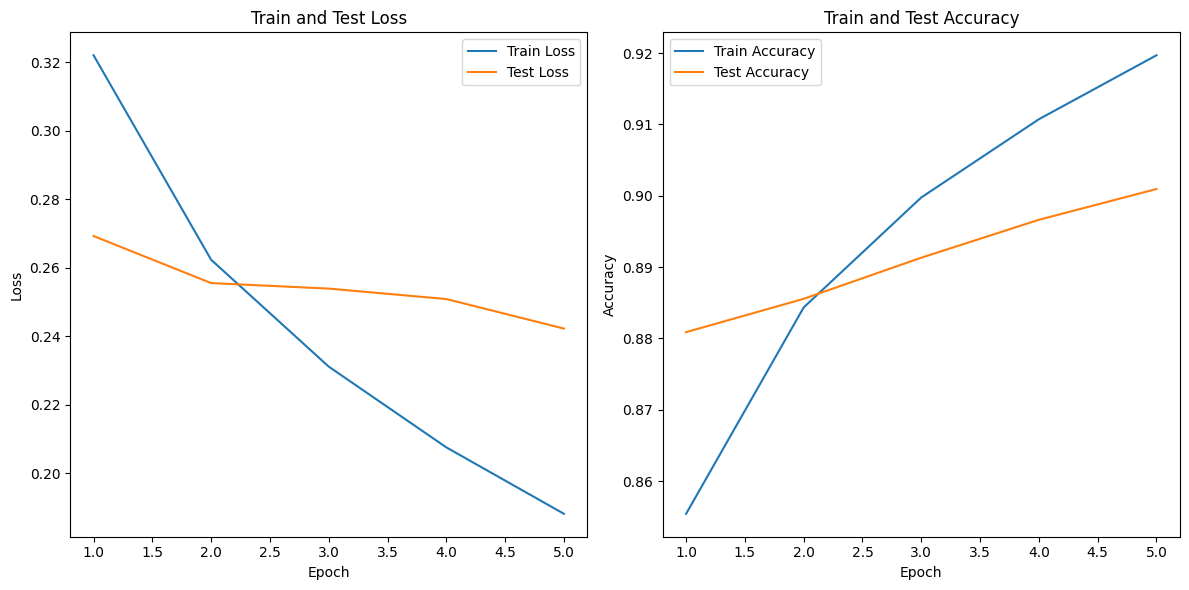

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load the date and divede it -80% for testing,20% to training
dataset = pd.read_csv("HateSpeechDatasetBalanced.csv")
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=30)

#train_dataset = train_dataset.sample(n=300, replace=False, random_state=30)
#test_dataset = test_dataset.sample(n=50, replace=False, random_state=30)

# Load the tokenizer  of BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


# Define  hate speech detection Dataset class ,this Class have the same
# idea  of the class that we used in hw2 (help us in go) give us in hw2
#this class helps in preparing text data for hate speech detection tasks
class Hate_speech(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        x=len(self.data)
        return x

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['Content']
        label = self.data.iloc[idx]['Label']
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

#create train,test objects
train_dataset = Hate_speech(train_dataset, tokenizer)
test_dataset = Hate_speech(test_dataset, tokenizer)

#create DataLoader for train,test objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


#defin the BERT_Net
class FTB_Net(nn.Module):
    def __init__(self, Bert_model):
        super(FTB_Net, self).__init__()
        self.Bert = Bert_model
        self.fc = nn.Linear(Bert_model.config.hidden_size, 2)

        for param in self.Bert.parameters():     #turn of all hidden layers
            param.requires_grad = False
        for param in self.Bert.encoder.layer[-2:].parameters(): #turn on last  layer
            param.requires_grad = True

    def forward(self, input_ids, attention_mask=None):
        output = self.Bert(input_ids=input_ids, attention_mask=attention_mask)
        output = output.pooler_output
        output = self.fc(output)        #classifaction layer
        return output

Bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)  #default num of layers is 12
model = FTB_Net(Bert_model).to(device)

optimizer = AdamW(model.parameters(), lr=0.00005)


# Lists to store training and testing metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# train and test functions
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct_samples = 0
    n_samples = 0

    for batch in tqdm(dataloader, desc="Training..."):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = F.cross_entropy(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        predictions = torch.argmax(outputs, dim=1)
        correct_samples += torch.sum(predictions == labels).item()
        n_samples += labels.size(0)

    acc = correct_samples / n_samples
    avg_train_loss = total_loss / len(dataloader)
    print(f"Train Loss: {avg_train_loss}, Train Accuracy: {acc}")

    # Append metrics for plotting
    train_losses.append(avg_train_loss)
    train_accuracies.append(acc)

def test(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct_samples = 0
    n_samples = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Testing..."):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_samples += torch.sum(predictions == labels).item()
            n_samples += labels.size(0)

    avg_test_loss = total_loss / len(dataloader)
    acc = correct_samples / n_samples
    print(f"Test Loss: {avg_test_loss}, Test Accuracy: {acc}")

    test_losses.append(avg_test_loss)
    test_accuracies.append(acc)

num_epochs = 5
for epoch in range(num_epochs):
    print(f"epoch: {epoch+1}")
    train(model, train_loader, optimizer, device)
    print("")

    test(model, test_loader, device)
    torch.save(model.state_dict(), f"FTB_epoch{epoch+1}.pth")

    plt.figure(figsize=(12, 6))

    # Plot train and test loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()

    # Plot train and test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()





plt.figure(figsize=(12, 6))

# Plot train and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plot train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

